# Exploratory Data Analysis - INFO 2201 Final Project
<hr>

## Table of Contents

    Intro

    Data Wrangling - Process of cleaning and loading data

    Data Visualizations - What did you find?

# Introduction
<hr>
    
After the summer of 2020, many people took to the streets to advocate for vulnerable populations in society. It was just after that summer that I would begin to hear people claim that the United States has a ratio of 5-8 times as many vacant homes as homeless people. Which is to say, their claim was that the US has plenty of homes to offer the homeless but won't. While I can agree with the sentiment, I wanted to personally critically examine data involved in this claim. In the spirit of advocacy from a sociological perspective, I will also be unpacking the homeless population data across demographics to expose any observable inequities.

    What are you trying to answer?
Specifically, I would like to know: "What is the ratio of vacant homes to the homeless population aggregated across the United States?"

    Where is the data from?
US Census Bureau,
US Department of Housing and Urban Development,
Federal Reserve back of St. Louis (research dept.)

In [1]:
# Project Dependencies
import pandas as pd
import numpy as np
import seaborn as sb  # using this instead of matplotlib for catplot()
import matplotlib.pyplot as plt
import requests
import json

from config import CENSUS_API_KEY

%matplotlib inline

# Data Wrangling

In [2]:
# US Census Bureau - Housing Vacancies and Home Ownership
api_key = CENSUS_API_KEY
hv_API_query1 = "get=cell_value,time_slot_id,category_code&seasonally_adj&data_type_code&for=US&time=2021"
home_vac_ownership_q1 = f"https://api.census.gov/data/timeseries/eits/hv?{hv_API_query1}&key={api_key}"

# US Dept Housing and Urban Development - PIT estimates of Homeless people
pit_estimates_xl = "./data/us-housing-urban-dev/2007-2021-PIT-Counts-by-State.xlsx"

# St. Louis Federal Reserve - Rental Vacancy Rates
rental_vacancy_rates_xl = "./data/stlouis-fed-reserve/RRVRUSQ156N.xls"

In [3]:
# Functions which return booleans whether or not
# a string belongs to a demographic group
def is_age(category_label: str) -> bool:
    if not category_label:
        return False
    
    if "Under 18" in category_label:
        return True
    
    elif "Age 18 to 24" in category_label:
        return True
    
    elif "Over 24" in category_label:
        return True
    else:
        return False

    
def is_gender(category_label: str):
    if not category_label:
        return False
    
    if "Female" in category_label:
        return True
    
    elif "Male" in category_label:
        return True
    
    elif "Transgender" in category_label:
        return True
    
    elif "Gender Non-Conforming" in category_label:
        return True
    else:
        return False


def is_race(category_label: str):
    if not category_label:
        return False
    
    if "Latino" in category_label:
        return True
    
    elif "White" in category_label:
        return True
    
    elif "Black" in category_label:
        return True
    
    elif "Asian" in category_label:
        return True
    
    elif "Native" in category_label:
        return True
    
    elif "Pacific Islander" in category_label:
        return True
    
    elif "Multiple Races" in category_label:
        return True
    else:
        return False


def is_chronic_homeless(category_label: str):
    if not category_label:
        return False
    
    if "Chronically Homeless" in category_label:
        return True
    else:
        return False

    
def is_veteran(category_label: str):
    if not category_label:
        return False
    
    if "Veteran" in category_label:
        return True
    else:
        return False

def is_family(category_label: str):
    if not category_label:
        return False
    
    if "Family" in category_label:
        return True
    elif "Families" in category_label:
        return True
    else:
        return False

def is_total(category_label: str):
    if not category_label:
        return False
    
    if "Total" in category_label:
        return True
    else:
        return False

    
def is_CoC(category_label: str):
    if not category_label:
        return False
    
    if "CoC" in category_label:
        return True
    else:
        return False
    

def category_labels(category):
    """
    Across the homelessness data, there were several categories which would be useful to compare within 
    such as age, gender, race/ethnicity, and chronic homelessness.

    Will be used to label data for aggregated comparisons.
    
    example use:
        df["category_labels"] = df["category"].apply(category_labels)
    """
    if not category:
        return 0
        
    if is_age(category):
        return "age"

    elif is_gender(category):
        return "gender"

    elif is_race(category):
        return "race"

    elif is_chronic_homeless(category):
        return "chronically-homeless"

    elif is_veteran(category):
        return "veteran"
    
    elif is_family(category):
        return "family"
    
    elif is_total(category):
        return "total"
    
    elif is_CoC(category):
        return "coc"
    
    else:
        return "unknown"
    

def region_labels(state:str, return_sub_region = False):
    """
    50 states are a lot of points to plot individually.
    This function will be used to assign each state a region and sub region label.
    
    example use:
    
        df["region_labels"] = df["state"].apply(region_labels)
        
        OR
        
        df["region_labels"], df["sub_region_labels"] = df["state"].apply(lambda x: region_labels(x, True))
        
    """
    
    us_regions = {
    "North-East": {
        "New England": ["ME", "NH", "VT", "MA", "RI", "CT"],
        "Mid-Atlantic": ["NY", "NJ", "PA"]
    },
    
    "Midwest": {
        "East North Central": ["IL", "IN", "MI", "OH", "WI"],
        "West North Central": ["IA", "KS", "MN", "MO", "NE", "ND", "SD"]
    },
    
    "South": {
        "South Atlantic": ["DE", "FL", "GA", "MD", "NC", "SC", "VA", "WV"],
        "East South Central": ["AL", "KY", "MS", "TN"],
        "West South Central": ["AR", "LA", "OK", "TX"]
    },
    
    "West": {
        "Mountain": ["AZ", "CO", "ID", "MT", "NV", "NM", "UT", "WY"],
        "Pacific": ["AK", "CA", "HI", "OR", "WA"]
    }}
    
    # Matches the given "state" argument to a region and sub-region
    for region in us_regions:
        for sub_region in us_regions[region]:
            if state in us_regions[region][sub_region]:
                
                if not return_sub_region:
                    return region
                else:
                    return region, sub_region
                

def presentation_columns(title: str):
    """
    Cleans up the demographic group names for plotting.   
    """
    # If the title splits, then it is split on " - "
    # Otherwise, alternative string
    if len(title.split(" - ")) > 1:
        return title.split(" - ")[1].replace(", 2021", "")
    else:
        return title.replace("Sheltered ", "").replace(", 2021", "")


def contains_null(DataFrame):
    if not DataFrame.isnull().values.any():
        print("No null values found in this dataset!")
    else:
        print("There are null values present in the dataset!")

## Data Analysis

### Home Vacancy and Ownership rates
<hr>

This data comes from the US Census Bureau, however it is important to keep in mind that due to public health safety procedures there are large gaps in data collection (see: [COVID-19s impact on Census Data collection](https://www.census.gov/housing/hvs/files/qtr420/impact_coronavirus_20q4.pdf)) since the beginning of the COVID-19 pandemic and this has affected counts especially in more remote regions in the United States. 

In [4]:
home_vac_ownership_data = requests.get(home_vac_ownership_q1).json()
home_vac_ownership_df = pd.DataFrame(home_vac_ownership_data[1:], columns=home_vac_ownership_data[0])

# Converts the column "cell_value" from strings to floats, row-wise
home_vac_ownership_df["cell_value"] = home_vac_ownership_df["cell_value"].apply(float)

In [5]:
contains_null(home_vac_ownership_df)

No null values found in this dataset!


In [6]:
home_vac_ownership_df.head()

,cell_value,time_slot_id,category_code,seasonally_adj,data_type_code,time,us
0,2649.0,0,ESTIMATE,no,RENT,2021-Q4,1
1,43387.0,0,ESTIMATE,no,RNTOCC,2021-Q1,1
2,43700.0,0,ESTIMATE,no,RNTOCC,2021-Q2,1
3,44041.0,0,ESTIMATE,no,RNTOCC,2021-Q3,1
4,44055.0,0,ESTIMATE,no,RNTOCC,2021-Q4,1


Judging from the "data_type_code" column, we will need a DataFrame containing all the rows marked with "VACANT". 

In [7]:
# Average across rows marked as vacancies (Q1-Q4, 2021)
vacancy_rate_yr = home_vac_ownership_df[home_vac_ownership_df["data_type_code"] == "VACANT"].copy()
vacancy_rate_yr["Quarter"] = home_vac_ownership_df["time"].apply(lambda x: x[-1:])

In [8]:
vacancy_rate_yr.describe()

,cell_value
count,4.000000
mean,15370.500000
std,312.521466
min,15010.000000
25%,15160.000000
50%,15406.500000
75%,15617.000000
max,15659.000000


[Text(0.5, 1.0, 'Total Vacant Homes over 2021\n'),
 Text(0.5, 0, 'VACANT'),
 Text(0, 0.5, 'Number of Vacant Homes\n')]

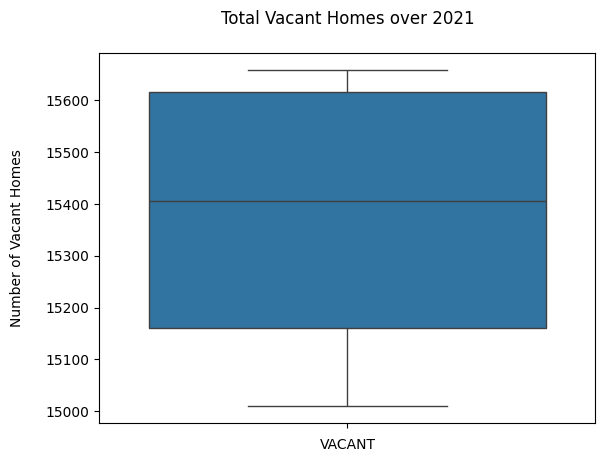

In [9]:
vacancy_boxplot = sb.boxplot(data=vacancy_rate_yr, y="cell_value")
vacancy_boxplot.set(
    title="Total Vacant Homes over 2021\n",
    xlabel="VACANT",
    ylabel="Number of Vacant Homes\n"
)

Using the DataFrame.describe() method is a quick way to generate a helpful table of summary statistics and the boxplot below visually confirms the statistical description from the table above.

Some measures to take note of:

| Number of Vacant Homes | count |
| :--- | :--: |
|Minimum |14,975|
|Mean|15,347|
|Median|15,386|
|Max|15,639|
    
Knowing the minimum and the maximum of the distribution of data illuminates outliers which might skew our average. The median is the "middle most" value which means that 50% of all datapoints lie below/above it. The mean and the median having a difference of $40$ vacant homes means the average (in this case) does a good job of describing the middle of the data.

From this, I would say that at any given point in the year of 2021, a person could expect $15,347$ homes to be vacant (give or take 320 homes).

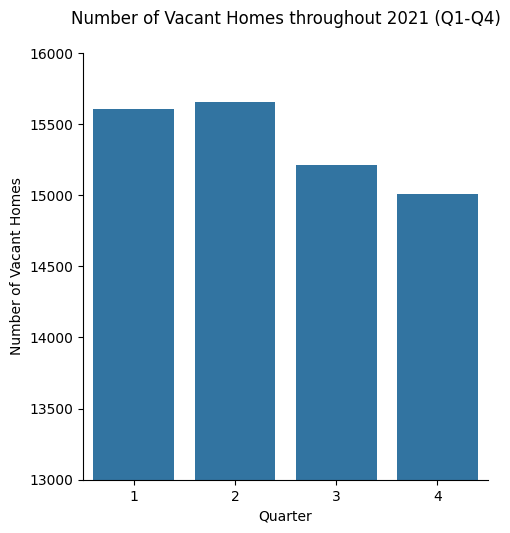

In [10]:
home_vacancies_plot = sb.catplot(data=vacancy_rate_yr, 
                                 x="Quarter", 
                                 y="cell_value", 
                                 kind="bar")
home_vacancies_plot.set(
    ylim=(13_000, 16_000), 
    ylabel="Number of Vacant Homes",
    title="Number of Vacant Homes throughout 2021 (Q1-Q4)\n"
)

To get a better idea of the quantity of vacant homes over the course of 2021, I measured each Quarter on the x-axis and the Number of Vacant Homes on the y-axis. By adding the dimension of time on the x-axis, this bar graph best demonstrates the change in the number of vacant homes over time.

From this visualization we can surmise that as 2021 continued, the number of vacant homes decreased from around $15,500$ to less than $15,000$.

# Homeless Population Estimate
<hr>

What is a PIT estimate?


According to the US Department of Housing and Urban development, the PIT estimate can be described like so:

    The Point-in-Time (PIT) count is a count of sheltered and unsheltered people experiencing homelessness on a single night in January.

In [11]:
# Dropped rows:
#    [3] America Samoa
#    [8] District of Columbia
#    [12] Guam
#    [27] Northern Mariana Islands
#    [42] Puerto Rico
#    [50] Virgin Islands
#    [56] Totals for dataset
non_state_territories = [3, 8, 12, 27, 42, 50, 56]

pit_estimates_df = pd.read_excel(pit_estimates_xl)
pit_estimates_df = pit_estimates_df.drop(non_state_territories, axis=0).reset_index(drop=True)

In preparing this next dataset, I found that the records belonging to United States non-state territories tended to be incomplete. This and in the interest of comparing Homeless Population Estimates in the United States I filtered the dataset to only include the offical 50 state territories.

In [12]:
contains_null(pit_estimates_df)

No null values found in this dataset!


In [13]:
pit_estimates_df.shape

(50, 349)

Just checking the shape of the data, there are 50 rows (one for each state in the US) and 349 columns. With that many columns compared to rows, this dataset is quite wide and untidy.

In [14]:
pit_estimates_df.head()

,State,Number of CoCs,"Sheltered ES Homeless, 2021","Sheltered ES Homeless - Under 18, 2021","Sheltered ES Homeless - Age 18 to 24, 2021","Sheltered ES Homeless - Over 24, 2021","Sheltered ES Homeless - Female, 2021","Sheltered ES Homeless - Male, 2021","Sheltered ES Homeless - Transgender, 2021","Sheltered ES Homeless - Gender Non-Conforming, 2021",...,"Sheltered Total Homeless Parenting Youth (Under 25) - Multiple Races, 2021","Sheltered ES Homeless Parenting Youth Under 18, 2021","Sheltered TH Homeless Parenting Youth Under 18, 2021","Sheltered Total Homeless Parenting Youth Under 18, 2021","Sheltered ES Homeless Parenting Youth Age 18-24, 2021","Sheltered TH Homeless Parenting Youth Age 18-24, 2021","Sheltered Total Homeless Parenting Youth Age 18-24, 2021","Sheltered ES Homeless Children of Parenting Youth, 2021","Sheltered TH Homeless Children of Parenting Youth, 2021","Sheltered Total Homeless Children of Parenting Youth, 2021"
0,AK,2,1360,145,151,1064,405,954,1,0,...,9,0,0,0,35,23,58,29,32,61
1,AL,8,1095,194,44,857,434,657,3,1,...,2,0,0,0,8,5,13,11,7,18
2,AR,5,1169,132,99,938,421,747,0,1,...,0,0,0,0,7,0,7,8,0,8
3,AZ,3,3822,921,206,2695,1709,2100,11,2,...,10,0,1,1,39,46,85,54,57,111
4,CA,44,40662,8268,2191,30203,17690,22701,208,63,...,38,1,4,5,373,254,627,497,295,792


After inspecting the datasets columns, I came up with the following groups to make comparisons on:

Aggregated into regions and subregions as defined by US Census Bureau's [economic regions](https://www2.census.gov/programs-surveys/economic-census/2017/guidance/geonotes/us/2017_EC_Regions.pdf):
    
    Region
    
    Subregion

<hr>

Demographics:

    Number of Continuums of Care

    Age

    Race

    Gender

    Chronically Homeless

In [15]:
# List comprehension which filters out the more granular categories in the data
# so we can focus on answering the question of "How many sheltered homeless people are estimated to live in the US?"
totals_columns = ["State", "Number of CoCs"] + [
    col 
    for col in pit_estimates_df.columns 
    if "Total" in col
    
    # Filtered out columns
    if "Families" not in col
    if "Individuals" not in col
    if "Youth" not in col
    if "Children" not in col
    if "Veterans" not in col
]
category_totals = pit_estimates_df[totals_columns].copy()

Among the columns containing totals for the homeless population estimates, I filtred specifically for the columns which contain the total population estimate per state, while preserving the different demographic groups. 

(For example "Age" has 3 groups: <18, 18-24, >24)

In [16]:
# Lambda work-around from article referenced below:
# https://www.adamsmith.haus/python/answers/how-to-apply-a-function-with-multiple-arguments-to-create-a-new-pandas-dataframe-column-in-python
category_totals["region_labels"] = category_totals["State"].apply(region_labels)
category_totals["sub_region_labels"] = category_totals["State"].apply(lambda x: region_labels(x, True)[1])

category_totals = category_totals.melt(id_vars=["region_labels", "sub_region_labels", "State"], var_name="demographic")

category_totals["demographic_category"] = category_totals["demographic"].apply(category_labels) 
category_totals["demographic"] = category_totals["demographic"].apply(presentation_columns)

While the cells above mostly dealt with loading and filtering the data, the cell immediately above is where most of the data transformation really takes off. Earlier in my analysis, I mentioned that the dataset was wider than it is tall and I address that issue here using the melt() method, so I could group demographics into their respective categories (e.g. "coc", "age", "race", etc).

In [17]:
# Splits dataframes into demographic categories for more granular comparisons
states_totals_df = category_totals[category_totals["demographic_category"] == "total"].copy()
CoC_df = category_totals[category_totals["demographic_category"] == "coc"].copy()
age_df = category_totals[category_totals["demographic_category"] == "age"].copy()
race_df = category_totals[category_totals["demographic_category"] == "race"].copy()
gender_df = category_totals[category_totals["demographic_category"] == "gender"].copy()
chrnc_df = category_totals[category_totals["demographic_category"] == "chronically-homeless"].copy()

In [18]:
sum_groupby = lambda x: x.groupby(["region_labels", "sub_region_labels", "demographic"]).agg({"value": "sum"}).reset_index()

regions_sum_groupby = states_totals_df.groupby(["region_labels", "demographic"]).agg({"value": "sum"}).reset_index()

sub_regions_sum_groupby = sum_groupby(states_totals_df)
coc_subregion_sum_groupby = sum_groupby(CoC_df)
race_subregion_sum_groupby = sum_groupby(race_df)
gender_subregion_sum_groupby = sum_groupby(gender_df)
chrnc_subregion_sum_groupby = sum_groupby(chrnc_df)

In these cells, I split the dataset up into its respective demographic groups and then aggregate the population estimates by subregion and region into sums. 

# PIT Estimate Totals Distribution

Before diving in too deeply into the individual demographic categories, I'd like to plot the distribution of the totals in the dataset. Since the graphs are primarily concerned with visualizing all demographic totals belonging to all 50 states, it should allow for me to get a better intuition of which datapoints could be considered outliers.

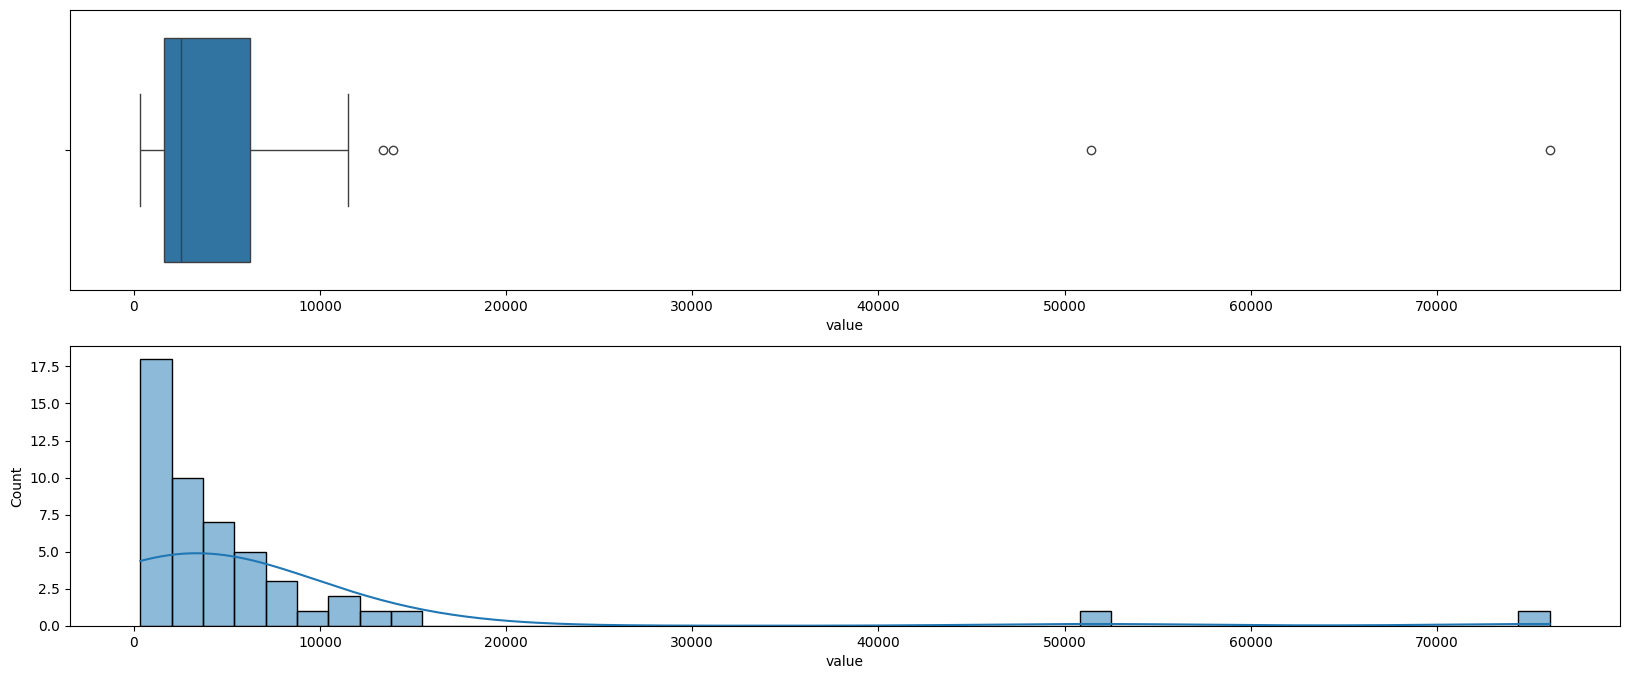

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))

totals_boxplot = sb.boxplot(ax=axes[0], data=states_totals_df, x="value")
totals_hist = sb.histplot(ax=axes[1], data=states_totals_df, x="value", bins=45, kde=True)

In [20]:
print("The Total Estimated Sheltered Homeless Population in the US: {0:,}".format(states_totals_df.value.sum()))

The Total Estimated Sheltered Homeless Population in the US: 320,992


# Total PIT Estimates by Region and Sub-region

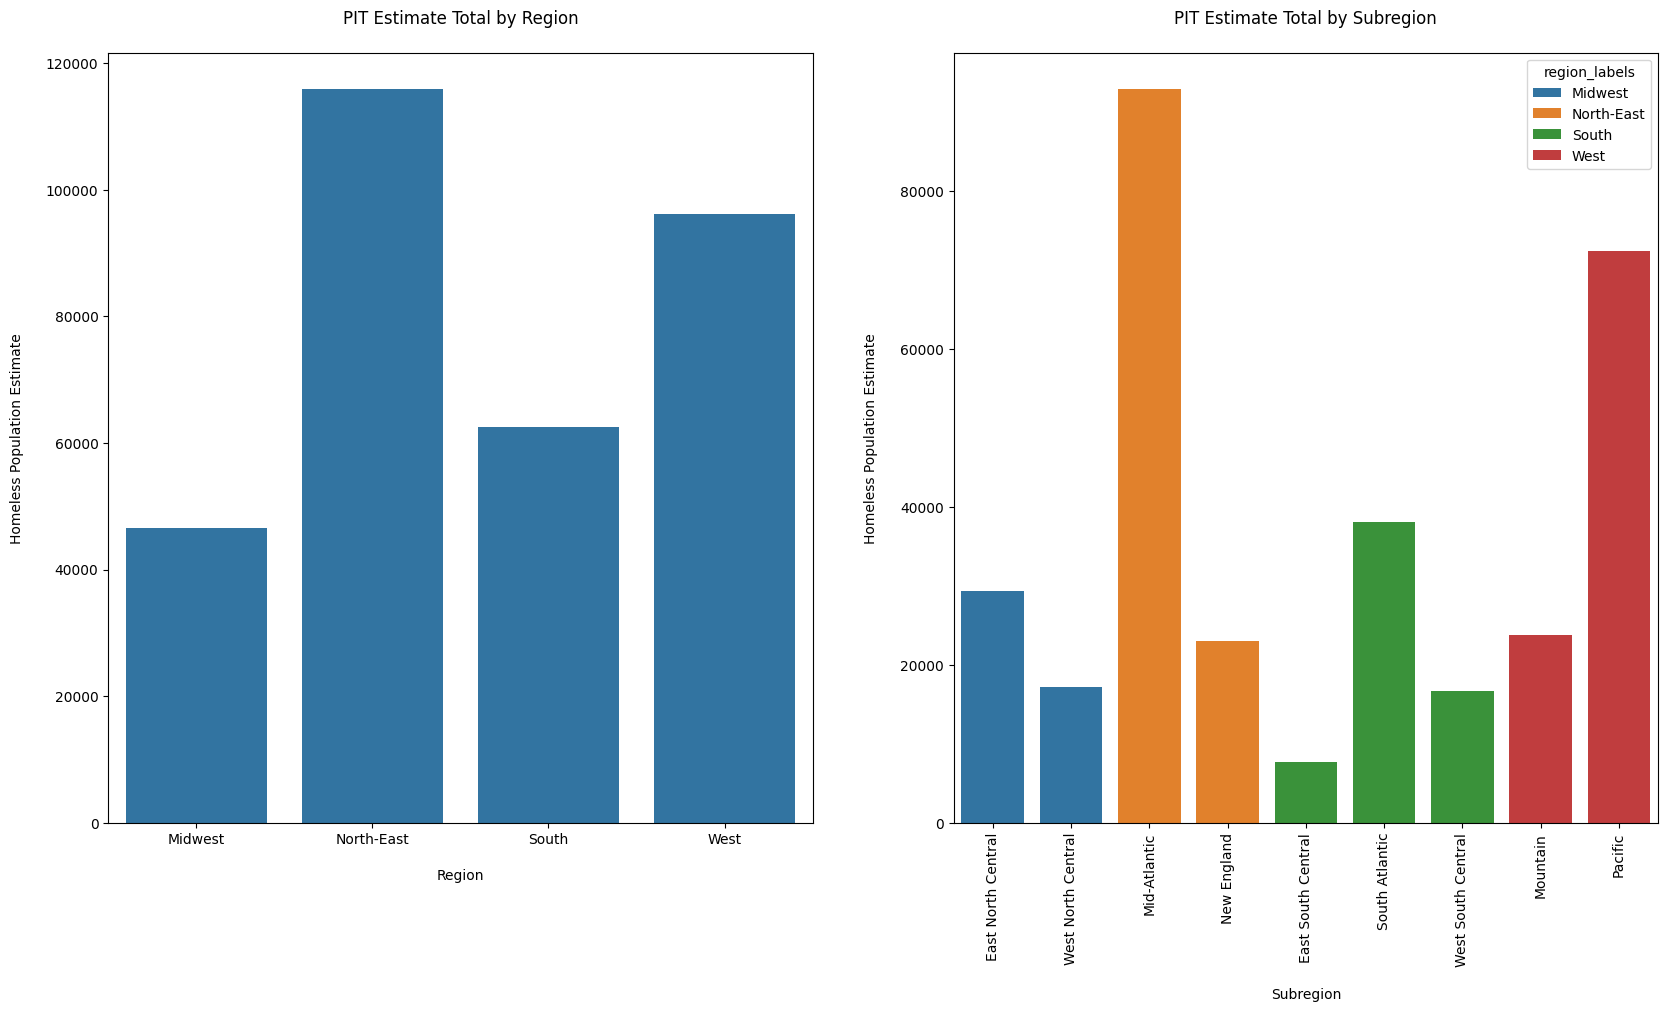

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Try to create a groupby "region_labels", get the sum for plotting here
regions_totals_barplot = sb.barplot(ax=axes[0], data=regions_sum_groupby, x="region_labels", y="value", errorbar=('ci', False))
regions_totals_barplot.set(
    title="PIT Estimate Total by Region\n", 
    xlabel="\nRegion", 
    ylabel="Homeless Population Estimate\n"
)

# Same thing here but with "sub_region_labels"
sub_regions_totals_barplot = sb.barplot(
    ax=axes[1], 
    data=sub_regions_sum_groupby, 
    x="sub_region_labels", 
    y="value",
    hue="region_labels",
    errorbar=('ci', False)
)
sub_regions_totals_barplot.set(
    title="PIT Estimate Total by Subregion\n", 
    xlabel="\nSubregion", 
    ylabel="Homeless Population Estimate\n"
)
sub_regions_totals_barplot.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
sub_regions_totals_barplot.set_xticklabels(sub_regions_totals_barplot.get_xticklabels(), rotation=90);

From the two barcharts above, a few things stand out to me:

1. The Mid-Atlantic and the Pacific reported significant PIT Estimates, especially compared to other subregions.
2. When looking at the PIT estimate totals across regions, the North-East and the West reported totals of just under 120,000 people and just under 100,000 people respectively.
3. While informative, using graphs alone can be less precise than I'd like so I'm going to aggregate the data into tables for more straightforward comparisons.

In [22]:
regions_sum_groupby.sort_values("value", ascending=False)

,region_labels,demographic,value
1,North-East,Total Homeless,115878
3,West,Total Homeless,96146
2,South,Total Homeless,62468
0,Midwest,Total Homeless,46500


In [23]:
sub_regions_sum_groupby.drop("region_labels", axis=1).sort_values("value", ascending=False)

,sub_region_labels,demographic,value
2,Mid-Atlantic,Total Homeless,92858
8,Pacific,Total Homeless,72405
5,South Atlantic,Total Homeless,38064
0,East North Central,Total Homeless,29287
7,Mountain,Total Homeless,23741
3,New England,Total Homeless,23020
1,West North Central,Total Homeless,17213
6,West South Central,Total Homeless,16689
4,East South Central,Total Homeless,7715


# Continuums of Care by Region and Sub-region

<strong>What are Continuums of Care?</strong>

According the the US department of Housing and Urban Development, Continuums of Care are described as follows:

    A Continuum of Care (CoC) is the group organized to carry out the responsibilities prescribed in the CoC Program Interim Rule for a defined geographic area. A CoC should be composed of representatives of organizations including: nonprofit homeless providers, victim service providers, faith-based organizations, governments, businesses, advocates, public housing agencies, school districts, social service providers, mental health agencies, hospitals, universities, affordable housing developers, law enforcement, organizations that serve homeless and formerly homeless veterans, and homeless and formerly homeless persons.
    
In my simple interpretation, a CoC is a network of organizations whose missions are to serve homeless populations.

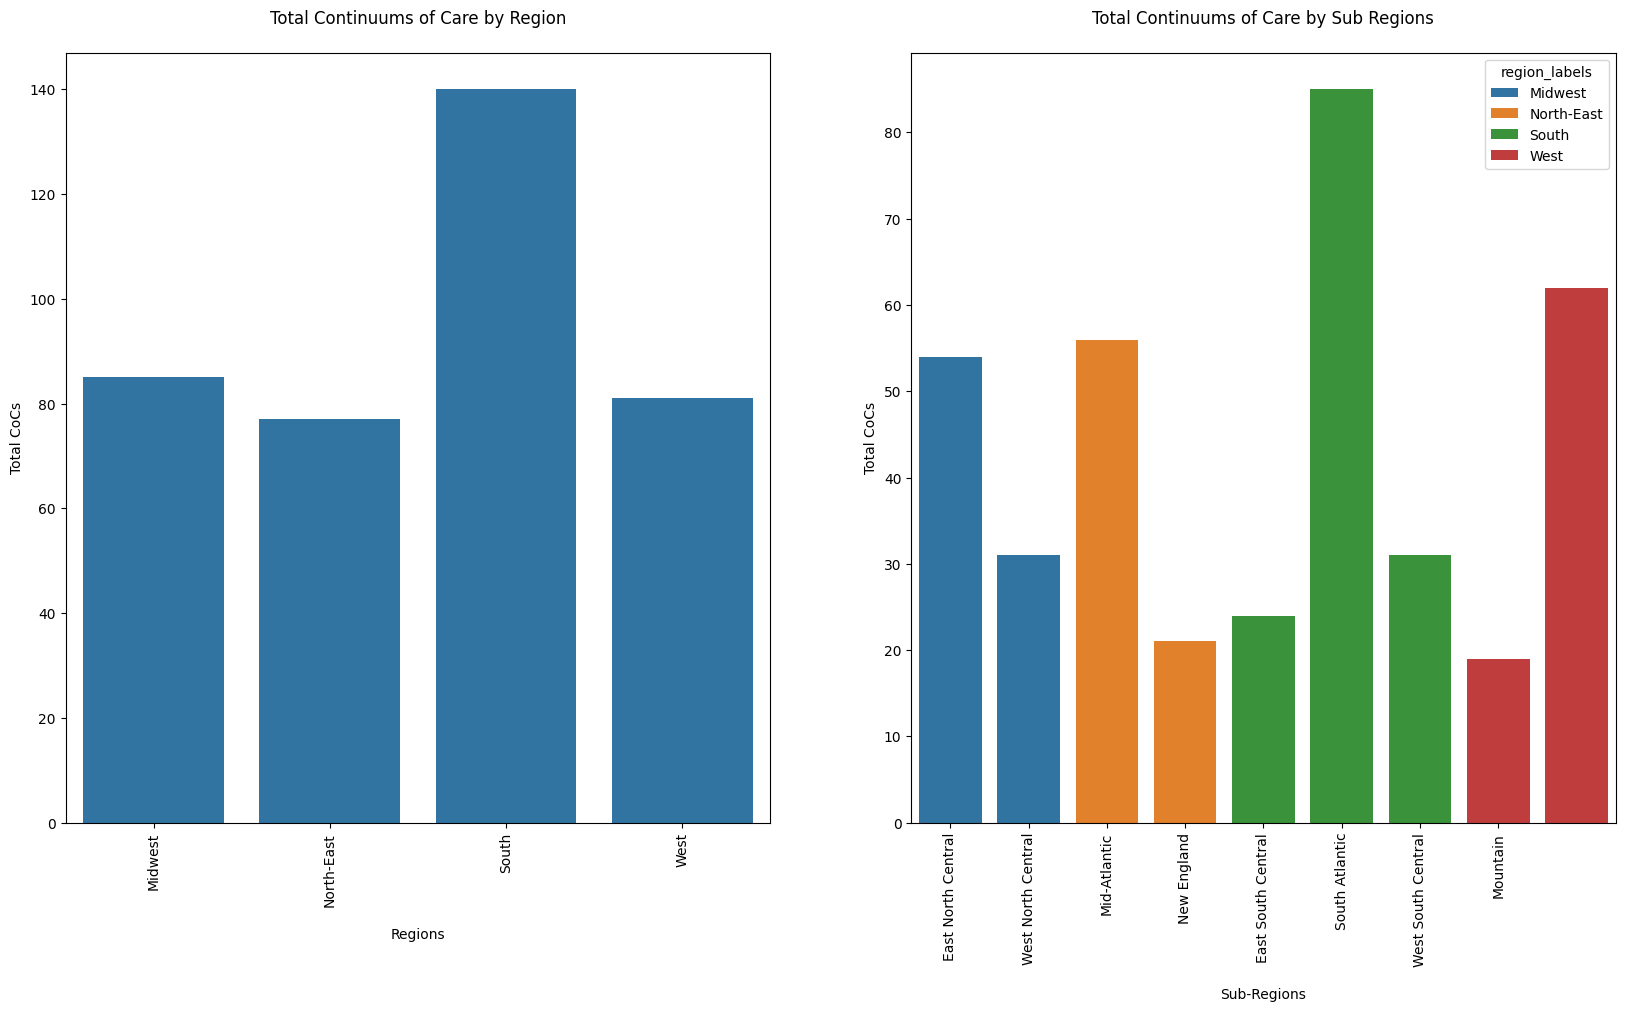

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Left plot
states_coc_sum_groupby = coc_subregion_sum_groupby.groupby("region_labels").sum().reset_index()
regions_CoC_barplot = sb.barplot(
    ax=axes[0],
    data=states_coc_sum_groupby,
    x="region_labels",
    y="value"
)
regions_CoC_barplot.set(title="Total Continuums of Care by Region\n", 
                           xlabel="\nRegions", 
                           ylabel="Total CoCs")
regions_CoC_barplot.set_xticks([0, 1, 2, 3])
regions_CoC_barplot.set_xticklabels(regions_CoC_barplot.get_xticklabels(), rotation=90);


# Right Plot
subregions_CoC_barplot = sb.barplot(
    ax=axes[1],
    data=coc_subregion_sum_groupby,
    x="sub_region_labels",
    y="value",
    hue="region_labels"
)
subregions_CoC_barplot.set(title="Total Continuums of Care by Sub Regions\n", 
                           xlabel="\nSub-Regions", 
                           ylabel="Total CoCs")
subregions_CoC_barplot.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
subregions_CoC_barplot.set_xticklabels(subregions_CoC_barplot.get_xticklabels(), rotation=90);

Several things of interest are revealed by the two barplots above:
1. The total number of Continuums of Care by subregion looks strikingly similar to the distribution of data as described by earlier visualizations of the totals by subregion. 
2. That said, the South Atlantic subregion has a significantly higher number of CoCs (>80) compared to other subregions.
3. On the barplot describing CoC totals by region, despite having much higher estimates of total homeless populations, the West and North-East have less CoCs than both the Midwest and especially the South.

# Age

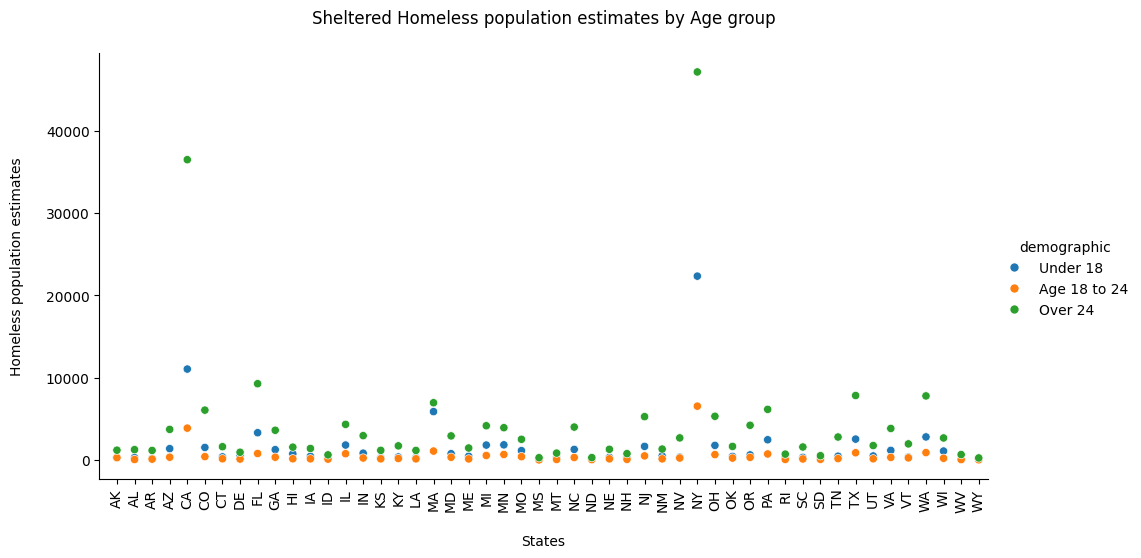

In [25]:
age_demo = category_totals[category_totals["demographic_category"] == "age"]

age_scatterplot = sb.relplot(data=age_demo, 
                             x="State", 
                             y="value", 
                             hue="demographic", 
                             aspect=2)
age_scatterplot.set(
    xlim=(-1, 49.5), 
    xlabel="\nStates",
    ylabel="Homeless population estimates\n",
    title="Sheltered Homeless population estimates by Age group\n"
)
age_scatterplot.set_xticklabels(rotation=90)

In the scatterplot above, I wanted to demonstrate a challenge I encountered when trying to plot 50 categorical variables (e.g. State names). While I can understand wanting to see statistics as they vary across states, visualizing this many categorical variables greatly reduces the overall readability of the graphic. 

According to this chart, most unhoused people are "Over 24" years old and this number is typically followed by the "Under 18" category which would make sense since the range of "Age 18 to 24" is significantly smaller than the former two.

# Race

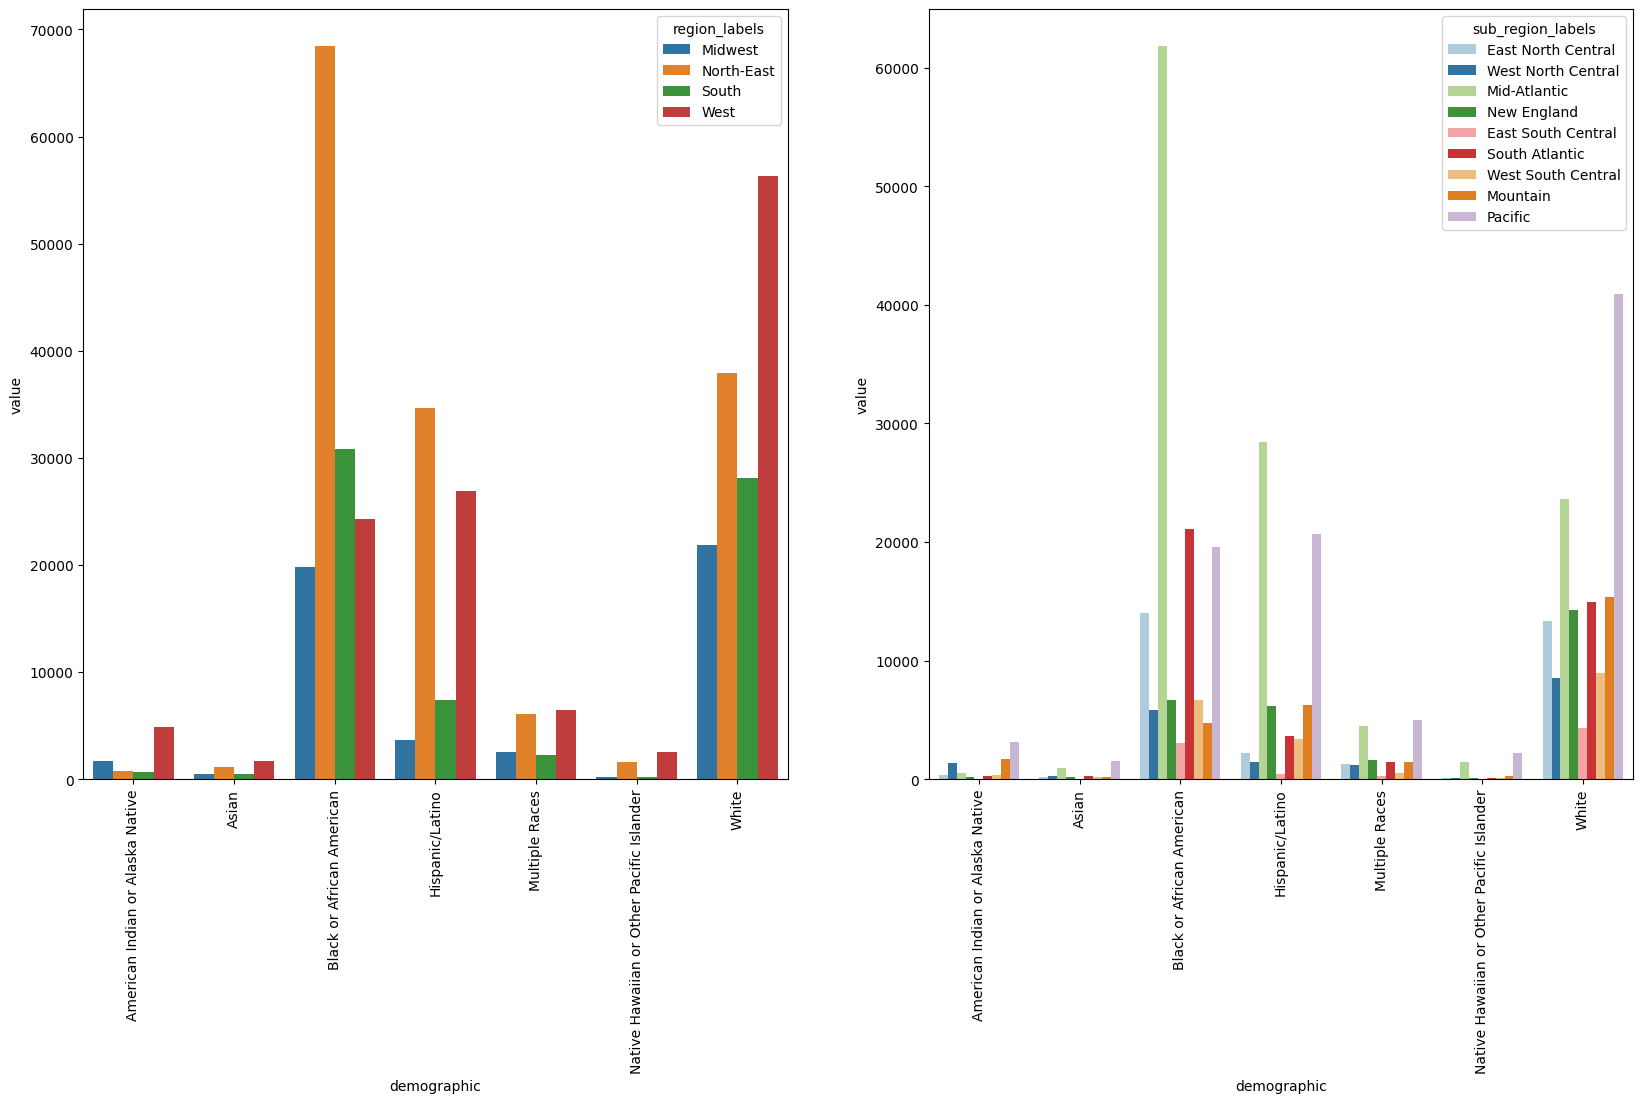

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# sub_region barplot
race_subregion_sum_groupby = race_subregion_sum_groupby[race_subregion_sum_groupby["demographic"] != "Non-Hispanic/Non-Latino"]
race_subregion_barplot = sb.barplot(ax=axes[1], 
                                    data=race_subregion_sum_groupby, 
                                    x="demographic", 
                                    y="value", 
                                    hue="sub_region_labels", 
                                    palette="Paired", 
                                    errorbar=('ci', False))
race_subregion_barplot.set_xticks([0, 1, 2, 3, 4, 5, 6])
race_subregion_barplot.set_xticklabels(race_subregion_barplot.get_xticklabels(), rotation=90);


# region barplot
# "Non-Hispanic/Non-Latino" is an aggregate (sum) label for non-Hispanic/Non-Latino races 
# which isn't particularly useful, so I exclude it from the visualization.
race_region_sum_groupby = race_subregion_sum_groupby.groupby(["region_labels", "demographic"]).agg({"value": "sum"}).reset_index()
race_region_sum_groupby = race_region_sum_groupby[race_region_sum_groupby["demographic"] != "Non-Hispanic/Non-Latino"]

race_region_barplot = sb.barplot(ax=axes[0], 
                                 data=race_region_sum_groupby, 
                                 x="demographic", 
                                 y="value", 
                                 hue="region_labels", 
                                 errorbar=('ci', False))
race_region_barplot.set_xticks([0, 1, 2, 3, 4, 5, 6])
race_region_barplot.set_xticklabels(race_region_barplot.get_xticklabels(), rotation=90);

For these graphics, I tried a new direction for visualizing differences across reported race and by region or subregion. Each of the racial categories is represented along the x-axis and the estimated totals for each group is then colored by their region labels and subregion labels.

From these visualizations, we can see that Black people are seemingly over-represented in both the Mid-Atlantic and the North-East more generally. To really understand the magnitude of these totals, I would want to set up a comparison with total populations by state; but for now I felt this to be out of the scope of this project.

# GENDER

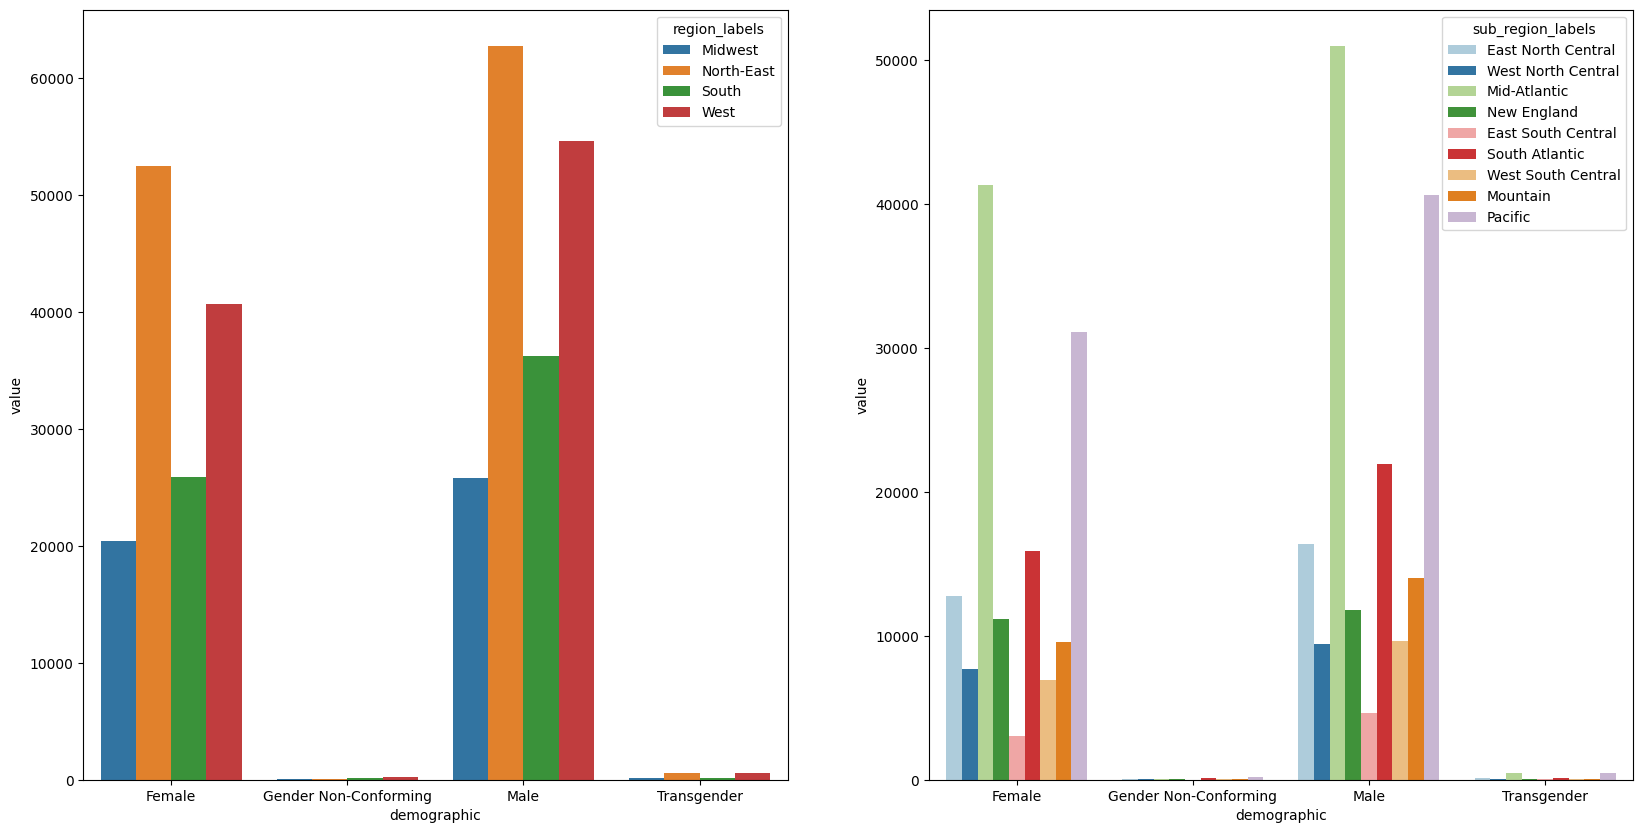

In [27]:
gender_region_totals = gender_subregion_sum_groupby.groupby(["region_labels", "demographic"]).agg({"value": "sum"}).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Left graph
gender_region_stripplot = sb.barplot(
    ax=axes[0], 
    data=gender_region_totals, 
    x="demographic", 
    y="value", 
    hue="region_labels"
)


# Right graph
gender_subregion_stripplot = sb.barplot(
    ax=axes[1], 
    data=gender_subregion_sum_groupby, 
    x="demographic", 
    y="value", 
    hue="sub_region_labels", 
    palette="Paired"
)

# Chronically-Homeless

[Text(0.5, 1.0, 'Total Chronically Homeless by Subregion'),
 Text(0.5, 0, '\nSubregions'),
 Text(0, 0.5, 'Total Chronically Homeless')]

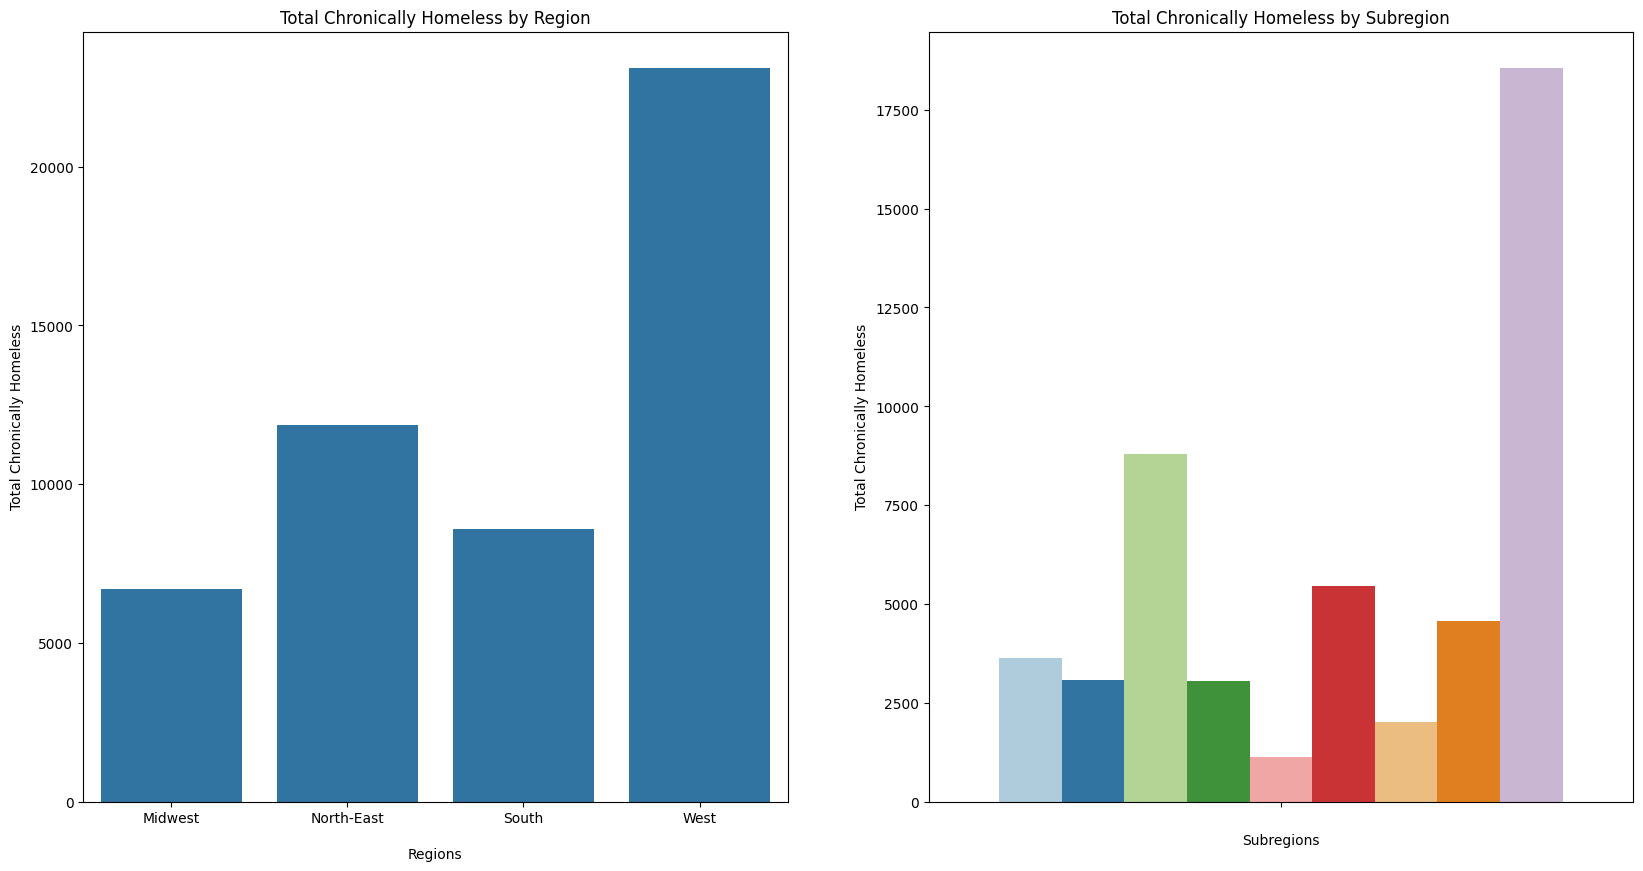

In [28]:
chrnc_region_totals = chrnc_subregion_sum_groupby.groupby(["region_labels", "demographic"]).sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Left Graph
chrnc_region_barplot = sb.barplot(ax=axes[0], 
                                  data=chrnc_region_totals , 
                                  x="region_labels", 
                                  y="value")
chrnc_region_barplot.set(title="Total Chronically Homeless by Region", 
                         xlabel="\nRegions", 
                         ylabel="Total Chronically Homeless")


# Right graph
chrnc_subregion_barplot = sb.barplot(
    ax=axes[1], 
    data=chrnc_subregion_sum_groupby, 
    hue="sub_region_labels", 
    y="value", 
    palette="Paired",
    legend=False
)
chrnc_subregion_barplot.set(title="Total Chronically Homeless by Subregion", 
                            xlabel="\nSubregions", 
                            ylabel="Total Chronically Homeless")

The total number of homeless people who are chronically homeless are represented at a significantly higher rate in the Pacific compared to other sub-regions. Almost $18,000$ people out of the total of $72,405$ in the Pacific subregion are chronically affected by homelessness. Meaning that 1 in 4 people experiencing homelessness in the Pacific subregion will have experienced homelessness for at least a year - or will experience homelessness frequently. 

In [29]:
total_vacancies = vacancy_rate_yr["cell_value"].mean()
total_homeless_people = states_totals_df["value"].sum()

# The (PIT) Total estimated homeless population in the US divided by the average number of vacant homes in 2021 
final_ratio = total_homeless_people / total_vacancies

print(f"For every vacant home in the United States, there are {round(final_ratio, 0)} people who are experiencing homelessness.")

For every vacant home in the United States, there are 21.0 people who are experiencing homelessness.


# Rental Vacancies rates from 1956 to 2021

In [30]:
rental_vacancy_rates_df = pd.read_excel(rental_vacancy_rates_xl)
rental_vacancy_rates_df = rental_vacancy_rates_df.dropna()
rental_vacancy_rates_df = rental_vacancy_rates_df.iloc[2:]
rental_vacancy_rates_df.columns = ["observation_dt", "vacancy_rate"]
rental_vacancy_rates_df["year"] =  rental_vacancy_rates_df["observation_dt"].apply(lambda x: int(x.strftime("%Y")))

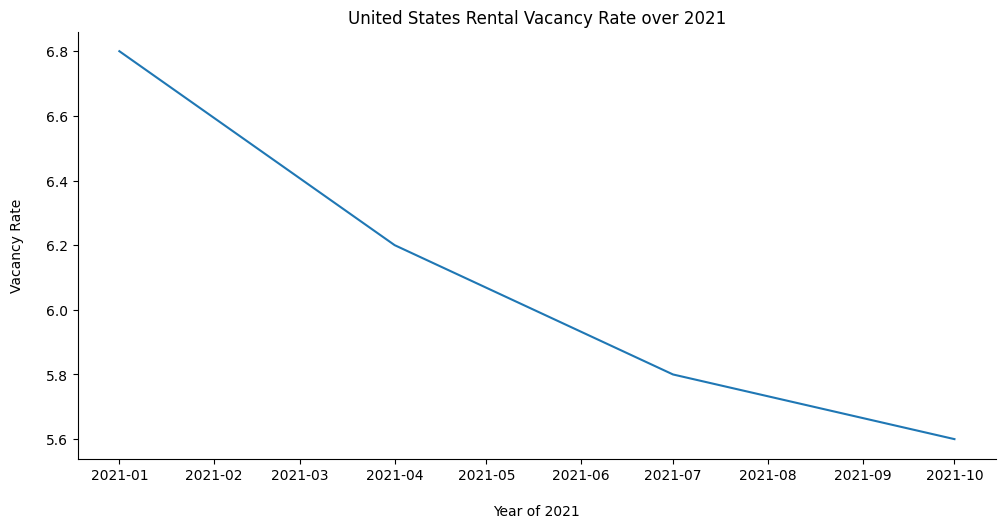

In [31]:
rental_vacancy_rates2021 = rental_vacancy_rates_df.sort_values("year", ascending=False).head(4)
rental_vacancy_rate2021_lplot = sb.relplot(
    data=rental_vacancy_rates2021, 
    x="observation_dt", 
    y="vacancy_rate", 
    kind="line", 
    aspect=2
)
rental_vacancy_rate2021_lplot.set(
    xlabel="\nYear of 2021",
    ylabel="Vacancy Rate\n",
    title="United States Rental Vacancy Rate over 2021"
)

<Axes: xlabel='observation_dt', ylabel='vacancy_rate'>

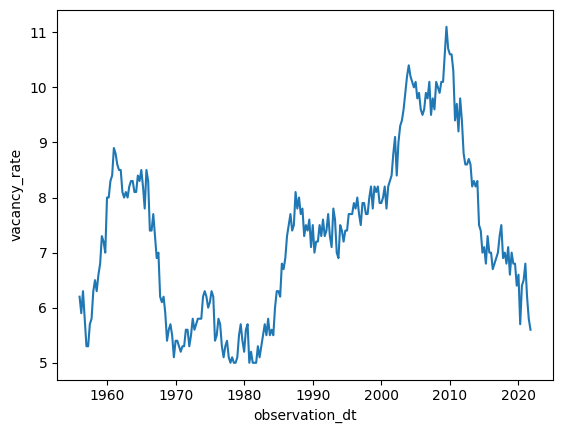

In [32]:
sb.lineplot(
    data=rental_vacancy_rates_df, 
    x="observation_dt", 
    y="vacancy_rate"
)

<Axes: xlabel='year', ylabel='vacancy_rate'>

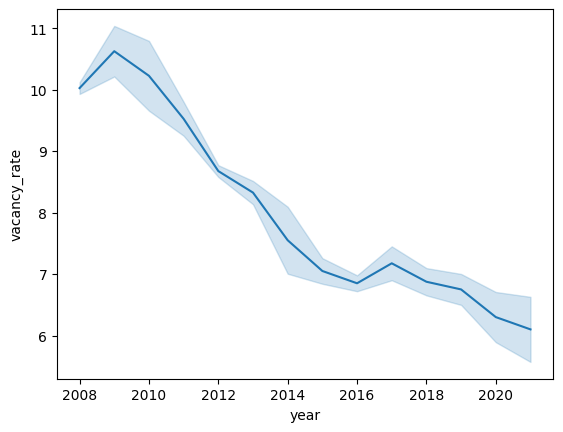

In [33]:
# Rental vacancies, from 2008 to-date
after_2008 = rental_vacancy_rates_df[rental_vacancy_rates_df["year"] >= 2008]
sb.lineplot(
    data= after_2008,
    x="year",
    y="vacancy_rate",
    errorbar="sd"
)

# Next useful comparisons
#    Number of home vacancies
#    Housing affordability data, if possible

### Challenges:
- Learned firsthand why we use long data > wide data for analysis and visualization.
    - Learned how to properly shape data using pd.melt()
- Created multiple tabular datasets from disparate datasources.
- Finding timely datasets that would effectively address the research question.